In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import seaborn as sns

In [2]:
def get_fn_without_ext(path, stem=True):
    """
    pathlib can't do .stub or .name when there's a period (.) in the fn
    """
    return ".".join(str(path).split("/")[-1].split(".")[:-1])

In [3]:
%%time
loc1 = list(set(Path("../../ad-config-search/12-02-results/").glob("**/*.csv")) - set(list(Path("../../ad-config-search/12-02-results/").glob("**/ray_results/**/*.csv"))))  # removing 4 folders which contain repeats
loc1 = list(Path("../../ad-config-search/12-02-results/").glob("**/*.csv"))
loc2 = list(Path("../../ad-config-search/12-03-v2/").glob("**/*.csv"))
loc3 = list(Path("../../ad-config-search/12-06-v8/").glob("**/*.csv"))
loc4 = list(Path("../../ad-config-search/12-06-v7/").glob("**/*.csv"))

CPU times: user 21.6 s, sys: 1min 16s, total: 1min 37s
Wall time: 1min 38s


In [4]:
from itertools import product

ranges = {
#     "dset_sector": ["000{}".format(x) for x in range(6)],
#     "scenario_id": ["S{}".format(x) for x in range(24)],
    "dset_scenario": list(product(["000{}".format(x) for x in range(6)], ["S{}".format(x) for x in range(24)]))+[("000{}".format(x), "S24") for x in range(2,6)],
    "edet_model": ["d{}".format(x) for x in (list(range(1,8))+["7x"])],
    "d_conf": [0.3, 0.5],
    "d_seq_pol": ["eager", "wait", "tail-aware", "infinite"],
    "t_min_iou": [0.1, 0.2, 0.3, 0.5],
    "t_max_age": [1,3,5,7],
    "t_every_nth": [1,3,5]
}

def get_base_str(dset_scenario, **kwargs):
    base_str = ("dataset=waymo_{dset_sector}_pl__"
        "run=training_{dset_sector}-{scenario_id}__"
        "D-model=efficientdet-{edet_model}__"
        "res-h=1280__res-w=1920__"
        "D-conf={d_conf}__"
        "D-seq-pol={d_seq_pol}__"
        "T-model=sort__"
        "T-min-iou={t_min_iou}__"
        "T-max-age={t_max_age}__"
        "T-ignore-len=1__"
        "T-every-nth-det={t_every_nth}"
    )
    return base_str.format(dset_sector=dset_scenario[0], scenario_id=dset_scenario[1], **kwargs)
    

all_names = [
    get_base_str(**dict(zip(ranges.keys(), combination))) for combination in tqdm(list(product(*ranges.values())))
]

100%|██████████| 454656/454656 [00:02<00:00, 165151.44it/s]


In [52]:
# Should have 148 * 8 * 2 * 4 * 4 * 4 * 3 = 454,656 csv files
assert(len(set(all_names)) == len(all_names)), "all_names shouldn't have repeats"
len(all_names)

454656

## The number which are missing, unexpected, repeating

In [104]:
all_csvs = loc1+loc2+loc3+loc4
len(all_csvs)

454656

In [105]:
# Check there are no missing or unexpected runs
unique_runs = set([get_fn_without_ext(x) for x in all_csvs])
unique_runs == set(all_names)

True

In [107]:
# check there are no repeats
for i, (expected_name, found_path) in enumerate(zip(sorted(all_names), sorted(all_csvs, key=lambda x:get_fn_without_ext(x)))):
    assert get_fn_without_ext(found_path) == expected_name, (i, expected_name, get_fn_without_ext(found_path))

In [108]:
before = None
repeating = []
for i, path in enumerate(sorted(all_csvs, key=lambda x: get_fn_without_ext(x))):
    fn = get_fn_without_ext(path)
    if before == fn:
        repeating.append(path)
    before = fn

In [109]:
set(repeating)

set()

## How many CSVs share the same directory?

In [144]:
seen = set()
repeats = []
for x in all_csvs:
    if x.parent not in seen:
        seen.add(x.parent)
    else:
        repeats.append(x)

In [145]:
len(repeats)

11840

## Get the timestamps from 0 to 200 to see which parts are most missing, get distribution of length of longest contiguous piece, get distribution of number of contiguous pieces

In [114]:
from ad_config_search.utils import prepend_line_to_file
def get_detection_tracking_accuracies(csv_path, mode, with_ts=False):
    csv_path = Path(csv_path)
    prepend_line_to_file(csv_path, "log_ts,simulator_ts,operator,extra_info,value")
    df = pd.read_csv(csv_path)
    eval_dict = {}
    eval_df = df[df["operator"] == "coco_detection_eval_operator_{}".format(mode)]
    for k in eval_df["extra_info"].unique():
        ts = eval_df[eval_df["extra_info"] == k]["simulator_ts"].values.astype(float)
        value = eval_df[eval_df["extra_info"] == k]["value"].values.astype(float)
        if with_ts:
            eval_dict["D_"+str(k)] = (ts - ts[0], value)
        else:
            eval_dict["D_"+str(k)] = value
    
    eval_df = df[df["operator"] == "tracking_eval_operator_{}".format(mode)]
    for k in eval_df["extra_info"].unique():
        ts = eval_df[eval_df["extra_info"] == k]["simulator_ts"].values.astype(float)
        value = eval_df[eval_df["extra_info"] == k]["value"].values.astype(float)
        if with_ts:
            eval_dict["T_"+str(k)] = (ts - ts[0], value)
        else:
            eval_dict["T_"+str(k)] = value
    return eval_dict

In [115]:
import ray

In [116]:
ray.shutdown()
ray.init(_redis_password="234k1234jlk2j34lkj34kj3kfjkfj", _temp_dir="/tmp/melih_is_using_the_default_ray_dir")

2020-12-20 16:09:58,860	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '169.229.48.125',
 'raylet_ip_address': '169.229.48.125',
 'redis_address': '169.229.48.125:6379',
 'object_store_address': '/tmp/melih_is_using_the_default_ray_dir/session_2020-12-20_16-09-57_964445_115441/sockets/plasma_store',
 'raylet_socket_name': '/tmp/melih_is_using_the_default_ray_dir/session_2020-12-20_16-09-57_964445_115441/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/melih_is_using_the_default_ray_dir/session_2020-12-20_16-09-57_964445_115441',
 'metrics_export_port': 44989,
 'node_id': '82ae49d26dd8c73b4a423ea0f995ac942c666edc'}

In [117]:
def ray_map(lst, fn, n):
    assert len(lst) > 1, len(lst)
    
    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
    
    @ray.remote
    def remote_version(arg_lst, load_bar=False):
        if load_bar:
            arg_lst = tqdm(arg_lst)
        result = [fn(arg) for arg in arg_lst]
#         print("done")
        return result
    
    pieces = chunks(lst, len(lst)//n)
    oids = [remote_version.remote(p, i==0) for i, p in enumerate(pieces)]
    list_of_lists = ray.get(oids)
    
    import itertools
    merged = list(itertools.chain.from_iterable(list_of_lists))
    return merged

In [118]:
def ray_map_np(lst, fn, n):
    assert len(lst) > 1, len(lst)
    
    def chunks(lst, n):
        """Yield successive n-sized chunks from lst."""
        for i in range(0, len(lst), n):
            yield lst[i:i + n]
    
    @ray.remote
    def remote_version(arg_lst, load_bar=False):
        if load_bar:
            arg_lst = tqdm(arg_lst)
        result = np.array([fn(arg) for arg in arg_lst])
#         print("done")
        return result
    
    pieces = chunks(lst, len(lst)//n)
    oids = [remote_version.remote(p, i==0) for i, p in enumerate(pieces)]
    list_of_lists = ray.get(oids)
    
    import itertools
    merged = np.concatenate(list_of_lists, axis=0)
    return merged

In [119]:
def get_bincount(csv):
    dct = get_detection_tracking_accuracies(csv, "timely", with_ts=True)
    if "T_mota" in dct:
        bincount = np.bincount(dct["T_mota"][0].astype(int)//100)
    else:
        bincount = np.zeros(200)
    return np.pad(bincount, (0, 200-len(bincount)))

### Also check if csvs in the repeated csv files (plotted orange) have a different distribution of missing data

In [120]:
all_bincounts = ray_map_np(all_csvs, get_bincount, 120)

100%|██████████| 3788/3788 [05:29<00:00, 11.51it/s]


In [122]:
all_bincounts.shape

(454656, 200)

In [148]:
repeat_csv_bincounts = ray_map_np(repeats, get_bincount, 120)

100%|██████████| 98/98 [00:09<00:00, 10.71it/s]


In [152]:
repeat_csv_bincounts.shape

(11840, 200)

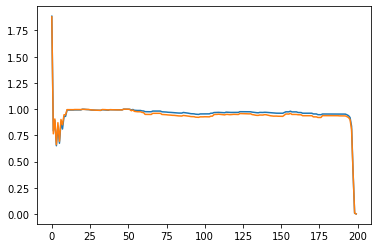

In [151]:
plt.plot(np.mean(all_bincounts, axis=0))
plt.plot(np.mean(repeat_csv_bincounts, axis=0))

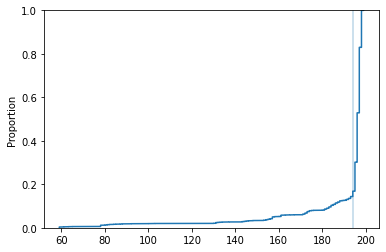

In [205]:
sns.ecdfplot(np.sum(all_bincounts, axis=1))
# sns.ecdfplot(np.sum(repeat_csv_bincounts, axis=1))
plt.axvline(x=194, alpha=0.3)

## Focusing on the files with the missing data (<194) to see if there's any observed correlations/commonality that would help inferring casuation

In [161]:
bincount_missing_data_tail = all_bincounts[np.sum(all_bincounts, axis=1) < 194]
csv_missing_data_tail = np.array(all_csvs)[np.sum(all_bincounts, axis=1) < 194]

In [162]:
len(csv_missing_data_tail)

65376

In [164]:
def split_run(run):
    return {x.split("=")[0]: x.split("=")[1] for x in run.split("__")}

In [176]:
df_missing_data_tail = pd.DataFrame([split_run(get_fn_without_ext(x)) for x in csv_missing_data_tail])

In [177]:
df_missing_data_tail = df_missing_data_tail.drop(columns=["T-ignore-len"])
df_missing_data_tail = df_missing_data_tail.drop(columns=["res-h"])
df_missing_data_tail = df_missing_data_tail.drop(columns=["res-w"])
df_missing_data_tail = df_missing_data_tail.drop(columns=["dataset"])

In [178]:
df_missing_data_tail["T-max-age"] = df_missing_data_tail["T-max-age"].astype(int)
df_missing_data_tail["T-every-nth-det"] = df_missing_data_tail["T-every-nth-det"].astype(int)
df_missing_data_tail["T-min-iou"] = df_missing_data_tail["T-min-iou"].astype(float)
df_missing_data_tail["D-seq-pol"] = df_missing_data_tail["D-seq-pol"].astype("category")
df_missing_data_tail["D-model"] = df_missing_data_tail["D-model"].astype("category")

In [208]:
df_missing_data_tail["num_datapoints"] = np.sum(bincount_missing_data_tail, axis=1)

In [209]:
df_missing_data_tail

,run,D-model,D-conf,D-seq-pol,T-model,T-min-iou,T-max-age,T-every-nth-det,num_datapoints
0,training_0000-S18,efficientdet-d1,0.5,infinite,sort,0.2,5,3,161
1,training_0000-S9,efficientdet-d3,0.3,eager,sort,0.5,3,3,184
2,training_0000-S18,efficientdet-d3,0.5,tail-aware,sort,0.2,5,5,161
3,training_0000-S18,efficientdet-d3,0.3,tail-aware,sort,0.1,5,5,161
4,training_0000-S12,efficientdet-d5,0.5,tail-aware,sort,0.1,5,5,186
...,...,...,...,...,...,...,...,...,...
65371,training_0001-S15,efficientdet-d2,0.5,wait,sort,0.5,5,5,156
65372,training_0002-S2,efficientdet-d7x,0.3,tail-aware,sort,0.5,7,3,188
65373,training_0002-S23,efficientdet-d1,0.3,tail-aware,sort,0.3,1,5,193
65374,training_0001-S3,efficientdet-d6,0.5,wait,sort,0.3,7,1,132


### Looks fairly even over all configuration knobs except for the scenario, which has a very small subset of the total 148 scenarios, and even then is uneven

<AxesSubplot:>

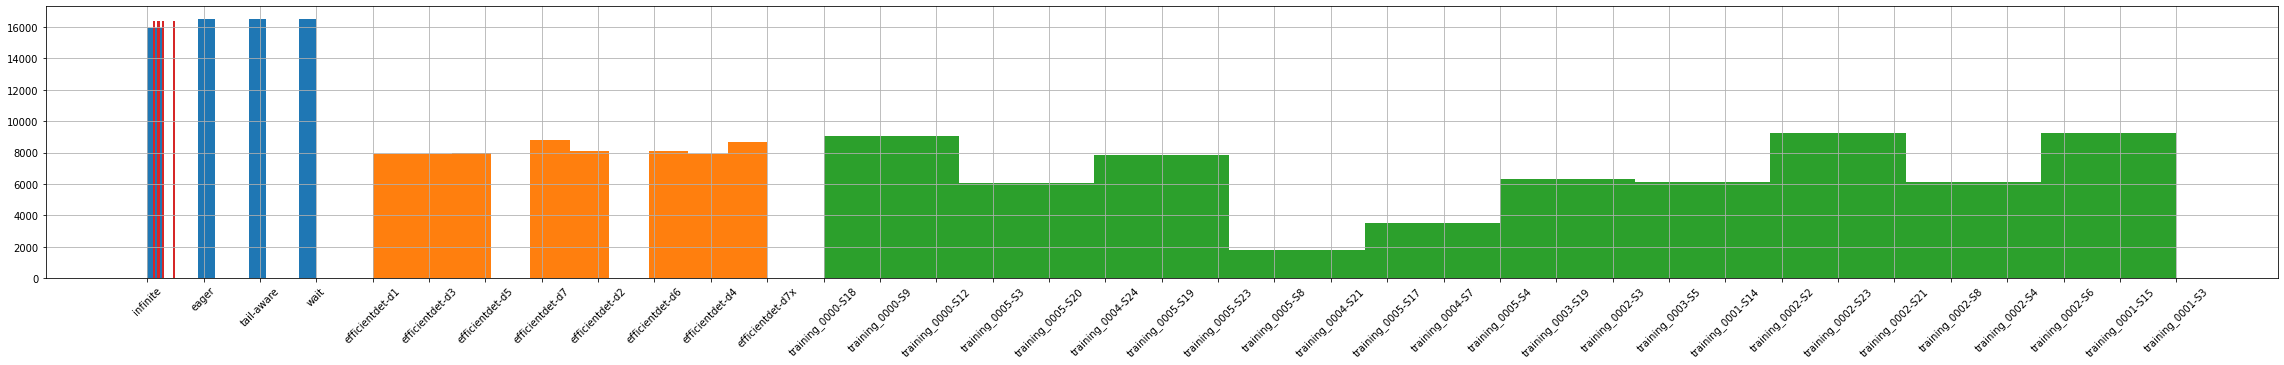

In [186]:
plt.figure(figsize=(40,5))
plt.xticks(rotation=45)
df_missing_data_tail["D-seq-pol"].hist()
df_missing_data_tail["D-model"].hist()
df_missing_data_tail["run"].hist()

<AxesSubplot:>

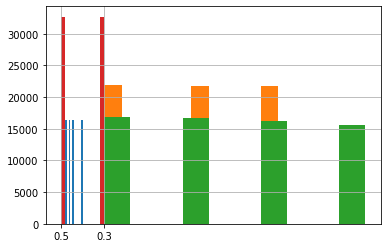

In [189]:
df_missing_data_tail["T-min-iou"].hist()
df_missing_data_tail["T-every-nth-det"].hist()
df_missing_data_tail["T-max-age"].hist()
df_missing_data_tail["D-conf"].hist()

In [210]:
# 8 * 3 * 4 * 4 * 4 * 3 = 3072 --> All of the runs in this scenario had < 194 datapoints
df_missing_data_tail["run"].value_counts()

training_0003-S19    3072
training_0002-S23    3072
training_0005-S23    3072
training_0001-S14    3072
training_0004-S24    3072
training_0002-S21    3072
training_0003-S5     3072
training_0002-S2     3072
training_0005-S20    3072
training_0001-S3     3072
training_0002-S8     3072
training_0004-S7     3072
training_0002-S4     3072
training_0000-S9     3072
training_0002-S3     3072
training_0002-S6     3072
training_0001-S15    3072
training_0000-S18    3072
training_0005-S3     3008
training_0000-S12    2920
training_0005-S19    1712
training_0004-S21    1024
training_0005-S8      768
training_0005-S17     448
training_0005-S4      200
Name: run, dtype: int64

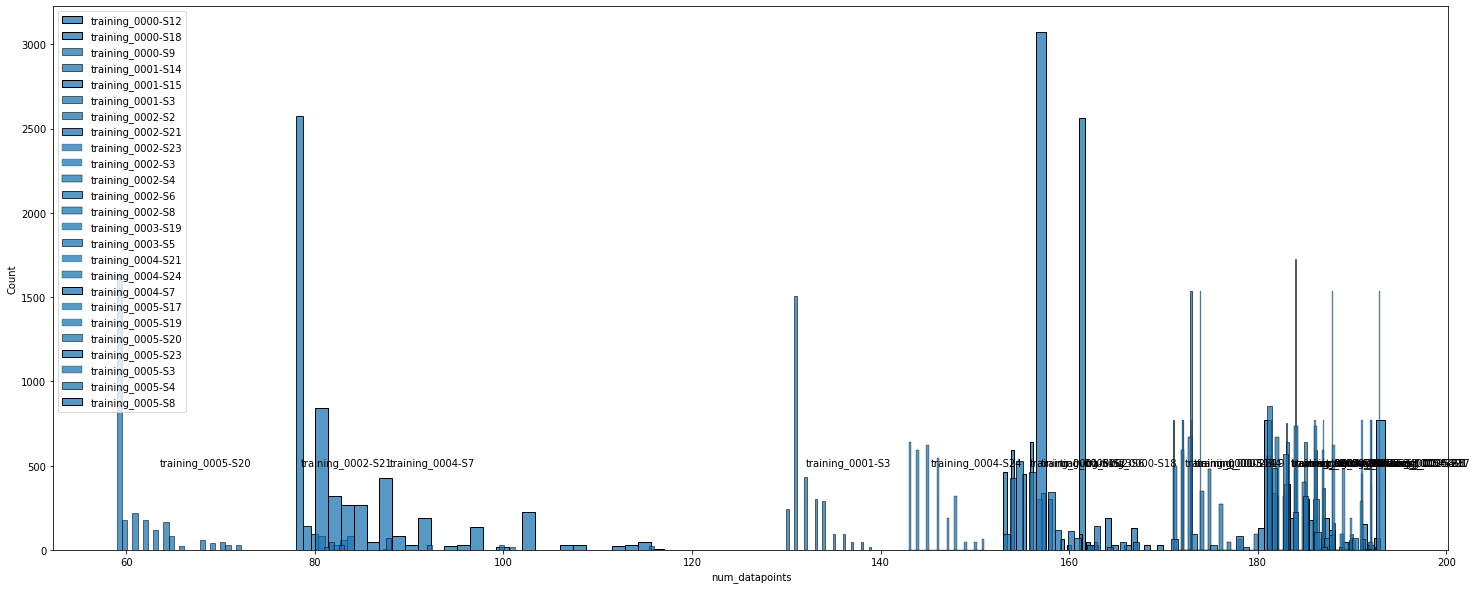

In [218]:
# Looks ugly, should be done in plotly express but whatever.
plt.figure(figsize=(25,10))
for (run, rows) in df_missing_data_tail.groupby("run"):
    sns.histplot(rows["num_datapoints"], label=run)
    plt.text(np.mean(rows["num_datapoints"]), 500, run)
# plt.ylim([0, 10])
plt.legend()

### It turns out data is missing by scenario and varies the way we see above because those scenarios just don't have many obstacles. For example in T5-S20 there is only a short segment where ground bounding boxes are available.